# Coregistration

In this notebook, we'll learn how to align two spatially overlapping rasters from Sentinel-2 and Landsat-8 into a single dataset on Planetary Computer using [stackstac](https://stackstac.readthedocs.io/en/latest/). We then calculate NDVI of the result dataset and compare to the NDVI calculated using the original data.

- Load STAC item data using [pystac](https://pystac.readthedocs.io/en/latest/)
- Reproject and resample so that Sentinel and Landsat data has the same resolution in the same coordinate system
- Crop out the region of interest and align Sentinel and Landsat data into a single dataset
- Calculate NDVI with [xrspatial](https://xarray-spatial.org/index.html)

In [1]:
import planetary_computer as pc

import numpy as np
import pandas as pd
import xarray as xr

import stackstac
import pystac

import xrspatial.multispectral as ms

## Local Dask Cluster

We use a small dataset so let's create a local Dask Cluster.

In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


## Data

The study area covers a small region of Missisippi River, USA, centered at St. Catherine Creek National Wildlife Refuge. We select a scene from Sentinel-2 and a scene from Lansat-8. Both are taken on the same date of `20200907`.

In [3]:
landsat_item_id = "LC08_L2SP_023038_20200907_20200918_02_T1"
landsat_item = pystac.read_file(
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/"
    f"landsat-8-c2-l2/items/{landsat_item_id}"
)
landsat_item = pc.sign_assets(landsat_item).to_dict()

landsat_item["id"], landsat_item["properties"]["proj:epsg"]

('LC08_L2SP_023038_20200907_20200918_02_T1', 32615)

In [4]:
sentinel_item_id = "S2B_MSIL2A_20200907T163839_N0212_R126_T15RXQ_20201101T160745.SAFE"
sentinel_item = pystac.read_file(
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/"
    f"sentinel-2-l2a/items/{sentinel_item_id}"
)
sentinel_item = pc.sign_assets(sentinel_item).to_dict()

sentinel_item["id"], sentinel_item["properties"]["proj:epsg"]

('S2B_MSIL2A_20200907T163839_N0212_R126_T15RXQ_20201101T160745.SAFE', 32615)

## Coregistration

Data can be well aligned if they are at the same resolution in the same coordinate systems. The 2 items are both in the coordinate system of `epsg=32615`. With `stackstac.stack`, we can provide value to `epsg` and `resolution` params in order to set the CRS and resolution for output data. In this example, we analyse data at 100m resolution and keep the `epsg` as is since they already matched.

In [5]:
sentinel_data = (
    stackstac.stack(
        sentinel_item,
        resolution=100,
        assets=["B02", "B03", "B04", "B08"],  # blue, green, red, nir
    )
    .where(lambda x: x > 0, other=np.nan)  # sentinel-2 uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)[0].persist()

sentinel_data.spec, sentinel_data.shape

(RasterSpec(epsg=32615, bounds=(600000, 3390200, 709800, 3500100), resolutions_xy=(100, 100)),
 (4, 1099, 1098))

Now set the bounds of Landsat data to be the same as of Sentinel data.

In [6]:
landsat_data = (
    stackstac.stack(
        landsat_item,
        resolution=100,
        bounds=sentinel_data.spec.bounds,
        assets=["SR_B2", "SR_B3", "SR_B4", "SR_B5"],  # blue, green, red, nir
    )
    .where(lambda x: x > 0, other=np.nan)  # landsat-8 sometimes uses 0 as nodata
    .assign_coords(band=lambda x: x.common_name.rename("band"))  # use common names
)[0].persist()

landsat_data.spec, landsat_data.shape

(RasterSpec(epsg=32615, bounds=(600000, 3390200, 709800, 3500100), resolutions_xy=(100, 100)),
 (4, 1099, 1098))

As can be seen, Sentinel and Landsat data now have the same raster spec information. Their x and y coords should all matched.

In [7]:
(landsat_data.x.data == sentinel_data.x.data).all()

True

In [8]:
(landsat_data.y.data == sentinel_data.y.data).all()

True

To visualize the data, we use [xrspatial.multispectral.true_color](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.true_color.html), which has 2 params `c` and `th` for contrast and brightness enhancement. Data are from different sources so we'll use different combinations of `c` and `th`.

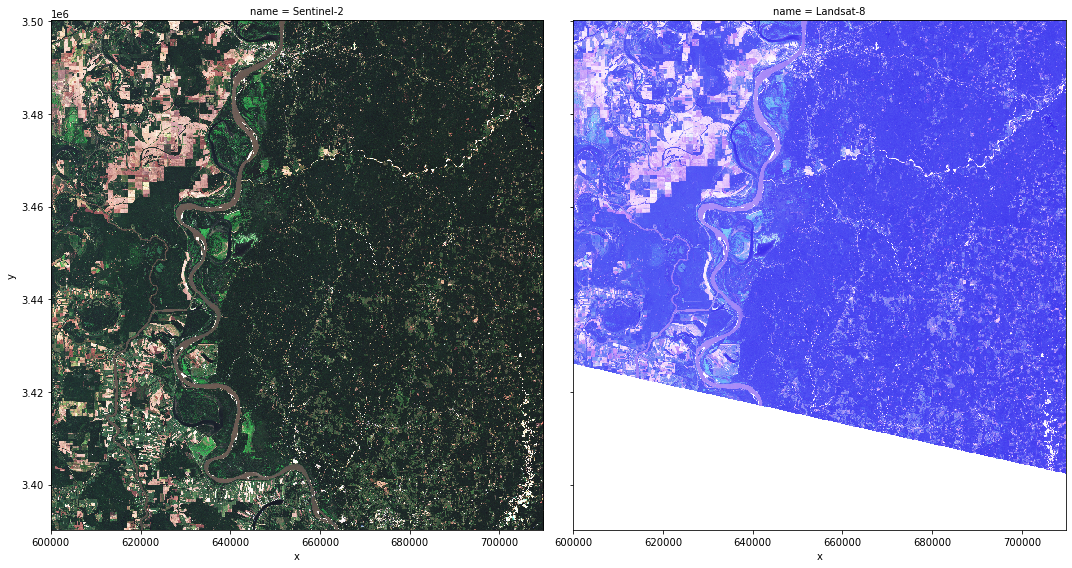

In [9]:
sentinel_image = ms.true_color(
    sentinel_data.sel(band="red"),
    sentinel_data.sel(band="green"),
    sentinel_data.sel(band="blue"),
    c=25,
    th=0.1,
    name="Sentinel-2",
)

landsat_image = ms.true_color(
    landsat_data.sel(band="red"),
    landsat_data.sel(band="green"),
    landsat_data.sel(band="blue"),
    c=20,
    th=0.15,
    name="Landsat-8",
)

org_imgs = xr.concat(
    [sentinel_image, landsat_image],
    pd.Index([sentinel_image.name, landsat_image.name], name="name"),
)

org_imgs.plot.imshow(x="x", y="y", col="name", figsize=(15, 8));

Create a dataset from Sentinel and Landsat data.

In [10]:
coregistration_data = xr.Dataset(
    data_vars=dict(
        sentinel=(["band", "y", "x"], sentinel_data),
        landsat=(["band", "y", "x"], landsat_data),
    ),
    coords=dict(
        x=sentinel_data.x.data,
        y=sentinel_data.y.data,
        band=sentinel_data.band.data,
    ),
    attrs=sentinel_data.attrs,  # 2 dataset have same projection attributes
)

coregistration_data

<xarray.Dataset>
Dimensions:   (band: 4, x: 1098, y: 1099)
Coordinates:
  * x         (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.096e+05 7.097e+05
  * y         (y) float64 3.5e+06 3.5e+06 3.5e+06 ... 3.39e+06 3.39e+06
  * band      (band) <U5 'blue' 'green' 'red' 'nir'
Data variables:
    sentinel  (band, y, x) float64 nan nan nan ... 2.42e+03 2.218e+03 2.166e+03
    landsat   (band, y, x) float64 8.073e+03 8.037e+03 8.104e+03 ... nan nan nan
Attributes:
    spec:        RasterSpec(epsg=32615, bounds=(600000, 3390200, 709800, 3500...
    crs:         epsg:32615
    transform:   | 100.00, 0.00, 600000.00|\n| 0.00,-100.00, 3500100.00|\n| 0...
    resolution:  100

## NDVI

Calculate NDVI with [xrspatial.multispectral.ndvi](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.ndvi.html)

In [11]:
sentinel_ndvi = ms.ndvi(
    nir_agg=coregistration_data.sentinel.sel(band="nir"),
    red_agg=coregistration_data.sentinel.sel(band="red"),
    name="sentinel_ndvi",
)

landsat_ndvi = ms.ndvi(
    nir_agg=coregistration_data.landsat.sel(band="nir"),
    red_agg=coregistration_data.landsat.sel(band="red"),
    name="landsat_ndvi",
)

Compute NDVI where the nir band is from Sentinel-2 and red band is from Landsat-8.

In [12]:
coregistration_ndvi = ms.ndvi(
    nir_agg=coregistration_data.sentinel.sel(band="nir"),
    red_agg=coregistration_data.landsat.sel(band="red"),
    name="coregistration_ndvi",
)

## Show results

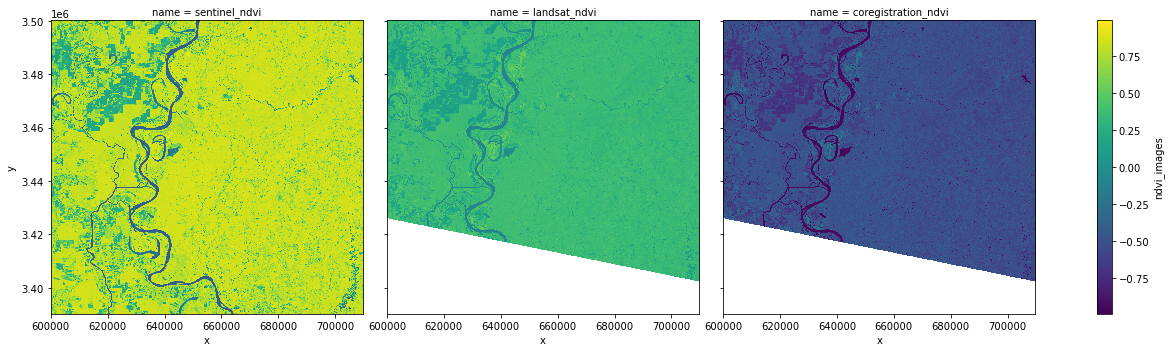

In [13]:
ndvi_imgs = xr.concat(
    [sentinel_ndvi, landsat_ndvi, coregistration_ndvi],
    pd.Index(
        [sentinel_ndvi.name, landsat_ndvi.name, coregistration_ndvi.name], name="name"
    ),
)

ndvi_imgs.name = "ndvi_images"

ndvi_imgs.plot.imshow(x="x", y="y", col="name", figsize=(18, 5), cmap="viridis");